In [2]:
!pip install awswrangler -q

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
import awswrangler as wr 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import json

## Load Data

In [4]:
monitor_hist = wr.s3.read_csv('s3://dd-ai-ml/raw_data/preprocessing/parse_data.csv')

In [5]:
## 형변환
monitor_hist['event_date'] = pd.to_datetime(monitor_hist['event_date'])
monitor_hist['event_date_min'] = pd.to_datetime(monitor_hist['event_date_min'])
monitor_hist['crops_start_date'] = pd.to_datetime(monitor_hist['crops_start_date'])
monitor_hist['crops_end_date'] = pd.to_datetime(monitor_hist['crops_end_date'])

## 컬럼명 변경
monitor_hist.columns = ['_'.join(col.split('$'))  if '$' in col else col for col in list(monitor_hist)]

In [6]:
## Test Model
monitor_hist = monitor_hist[:10000]

In [7]:
monitor_hist.shape

(10000, 59)

In [8]:
monitor_hist['event_date'].min(), monitor_hist['event_date'].max()

(Timestamp('2021-01-01 00:00:07.813000'),
 Timestamp('2021-01-07 22:56:12.813000'))

In [9]:
## 단일값 제거
for col in list(monitor_hist):
    if monitor_hist[col].nunique() <= 1:
        print(col)
        monitor_hist.drop(col, axis = 1, inplace = True)        

gsm_key
green_house_id
prd_code
crops_start_date
crops_end_date
top_window_1_auto_manual_mode
top_window_2_auto_manual_mode
side_window_1_auto_manual_mode
side_window_2
side_window_2_run_status
side_window_2_auto_manual_mode
dc_power_1
dc_power_1_run_status
dc_power_1_auto_manual_mode
ac_power_1
ac_power_1_run_status
ac_power_1_auto_manual_mode
heat_cover_1_auto_manual_mode
heat_cover_2
heat_cover_2_run_status
heat_cover_2_auto_manual_mode
float_fan_1_auto_manual_mode
exhaust_fan_1_auto_manual_mode


## Test

In [10]:
## col_n = 10, MSE = 400
target_base = ['sensor_inner_temperature1_1', 'sensor_inner_hum1_1', 'sensor_plantation_temperature_1_1',
          'sensor_plantation_hum_1_1', 'sensor_inner_co2_1', 'sensor_inner_temperature1_2',
          'sensor_inner_hum1_2', 'sensor_plantation_temperature_1_2', 'sensor_plantation_hum_1_2', 'sensor_inner_co2_2',]

target = [col+'_target' for col in target_base]
target

['sensor_inner_temperature1_1_target',
 'sensor_inner_hum1_1_target',
 'sensor_plantation_temperature_1_1_target',
 'sensor_plantation_hum_1_1_target',
 'sensor_inner_co2_1_target',
 'sensor_inner_temperature1_2_target',
 'sensor_inner_hum1_2_target',
 'sensor_plantation_temperature_1_2_target',
 'sensor_plantation_hum_1_2_target',
 'sensor_inner_co2_2_target']

In [11]:
train_df = monitor_hist[:int(len(monitor_hist) * 0.8)]
train_df[target] = train_df[target_base].shift(30)
train_df.reset_index(drop = True, inplace = True)
train_df.dropna(axis = 0, inplace = True)

test_df = monitor_hist[int(len(monitor_hist) * 0.8):]
test_df[target] = test_df[target_base].shift(30)
test_df.reset_index(drop = True, inplace = True)
test_df.dropna(axis = 0, inplace = True)

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-11-3c4641653af7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(axis = 0, inplace = True)
/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [12]:
train_x = train_df[[col for col in list(train_df) if col not in target]]
train_x = train_x.select_dtypes(include = ['int64', 'float64'])
train_y = train_df[[col for col in list(train_df) if col in target]]

test_x = test_df[[col for col in list(test_df) if col not in target]]
test_x = test_x.select_dtypes(include = ['int64', 'float64'])
test_y = test_df[[col for col in list(test_df) if col in target]]

In [13]:
train_x.shape, train_y.shape

((7970, 34), (7970, 10))

In [14]:
test_x.shape, test_y.shape

((1970, 34), (1970, 10))

In [15]:
import gc

gc.collect()

24495

In [16]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization, Conv1D, Input, MaxPooling1D, Flatten, Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K

tf.random.set_seed(1004)
K.clear_session()

model = Sequential([
    Input(shape = (train_x.shape[1:])),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(train_y.shape[1])
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae', 'mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1120      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 1,818
Trainable params: 1,818
Non-trainable params: 0
_________________________________________________________________


In [17]:
hist = model.fit(train_x, train_y, epochs=500, batch_size = 16, verbose = 1)

Epoch 1/500
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2023-05-30 02:11:54.467 tensorflow-2-6-gpu--ml-g4dn-xlarge-7eba0e151157af0bd8a25c896f03:82 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-05-30 02:11:54.492 tensorflow-2-6-gpu--ml-g4dn-xlarge-7eba0e151157af0bd8a25c896f03:82 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
499/499 [==============================] - 2s 2ms/step - loss: 5679080960.0000 - mae: 15057.3359 - mse: 5679080960.0000
Epoch 2/500
499/499 [==============================] - 1s 2ms/step - loss: 262736.8125 - mae: 220.7122 - mse: 262736.8125
Epoch 3/500
499/499 [==============================] - 1

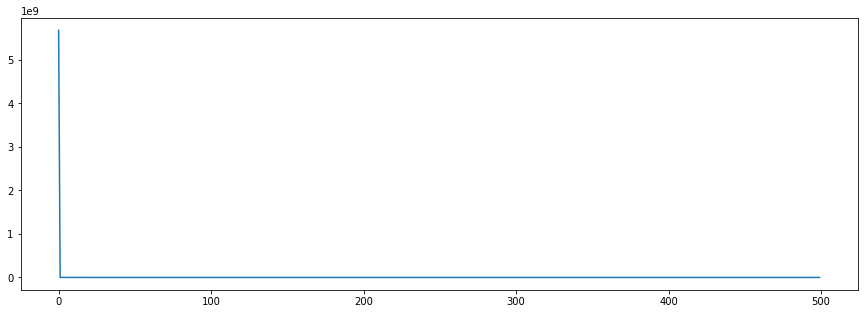

In [18]:
plt.figure(figsize = (15,5))
plt.plot(hist.history['loss'][:])
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt

In [32]:
pred = model.predict(train_x)
actual = train_y
print('TRAIN SCORE') 
print(f'MSE : {mean_squared_error(actual, pred)}')
print(f'RMSE : {np.sqrt(mean_squared_error(actual, pred))}')

actual_df = pd.DataFrame(columns = list(target), data = actual)
pred_df = pd.DataFrame(columns = list(target), data = pred)

TRAIN SCORE
MSE : 4866.340038788328
RMSE : 69.7591573830155


ERROR! Session/line number was not unique in database. History logging moved to new session 50


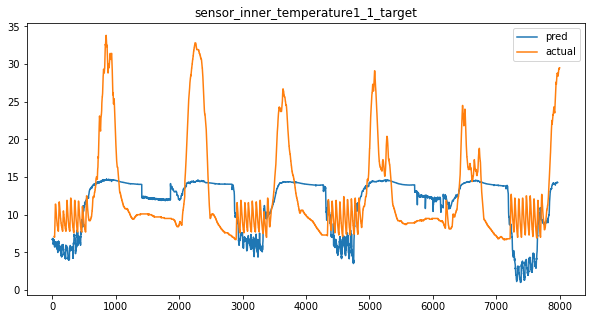

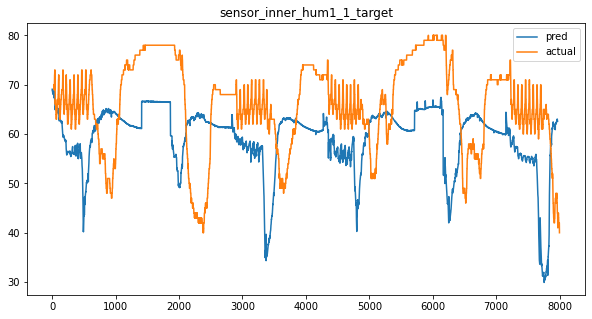

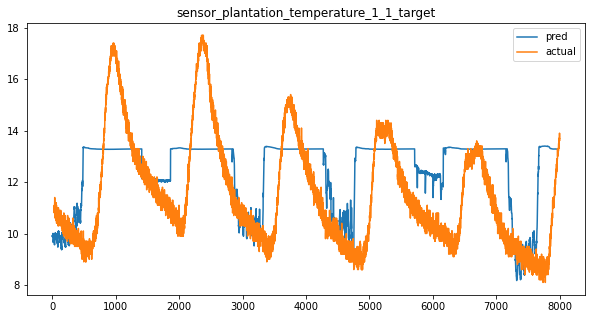

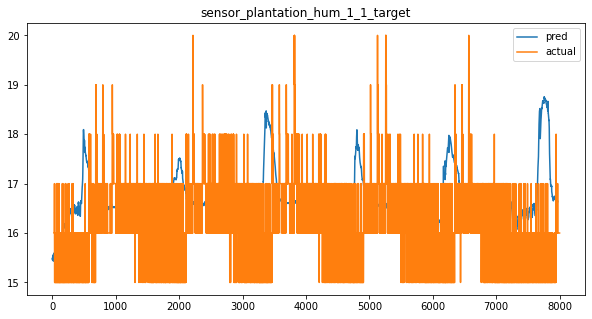

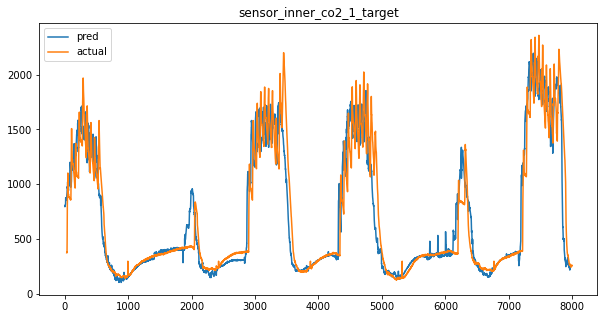

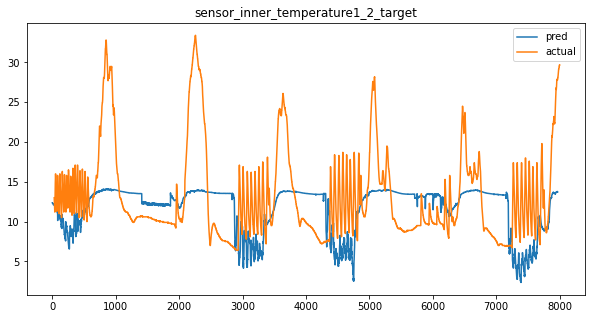

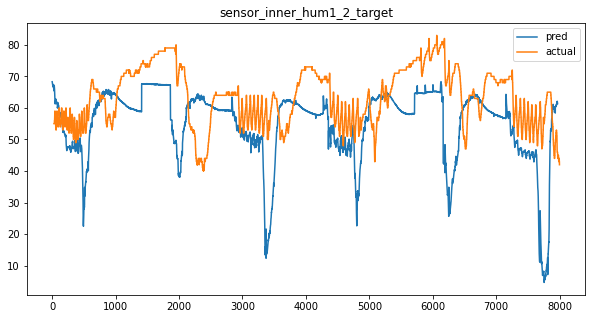

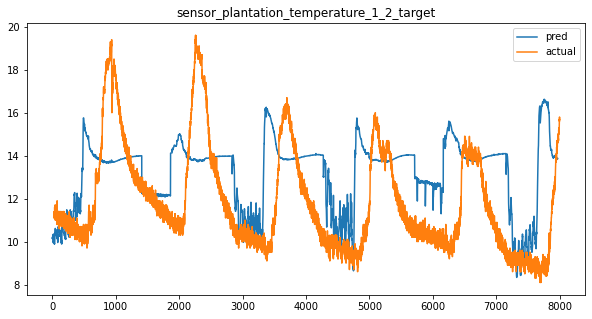

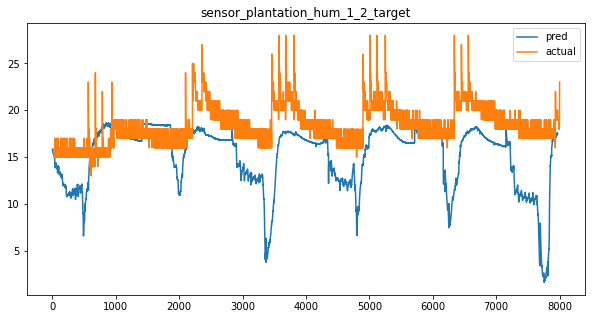

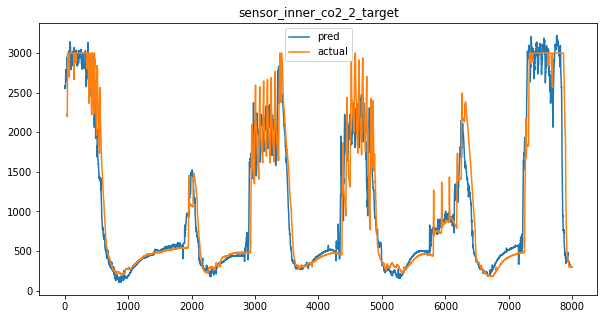

In [37]:
for col in list(pred_df):
    plt.figure(figsize = (10,5))
    plt.plot(pred_df[col])
    plt.plot(actual_df[col])
    plt.legend(['pred','actual'])
    plt.title(col)
    plt.show()
    input()

In [39]:
pred = model.predict(test_x)
actual = test_y
print('TEST SCORE') 
print(f'MSE : {mean_squared_error(actual, pred)}')
print(f'RMSE : {np.sqrt(mean_squared_error(actual, pred))}')

actual_df = pd.DataFrame(columns = list(target), data = actual)
pred_df = pd.DataFrame(columns = list(target), data = pred)

TEST SCORE
MSE : 1447.5405673615412
RMSE : 38.04655789110943


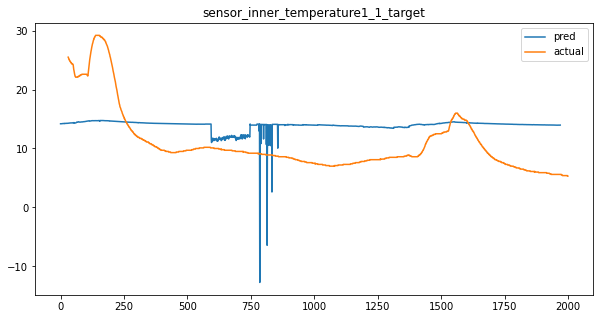

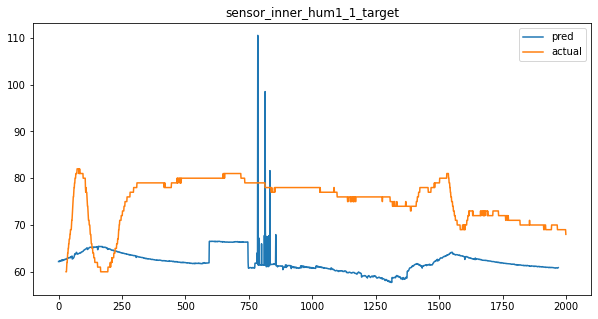

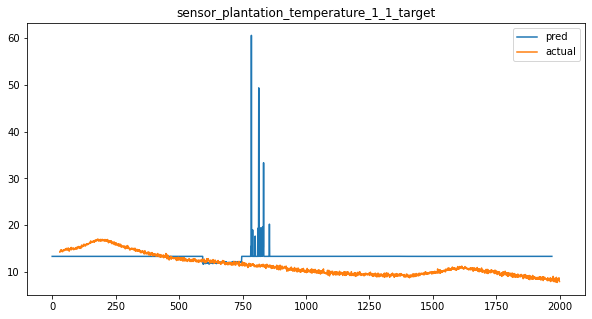

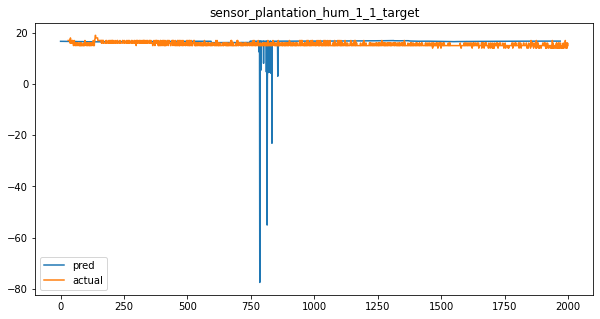

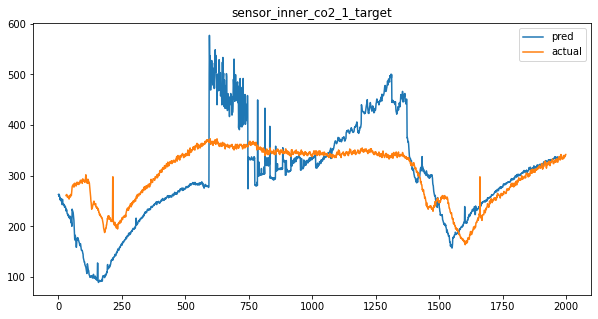

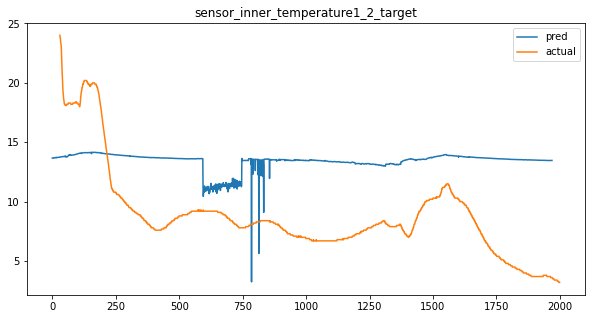

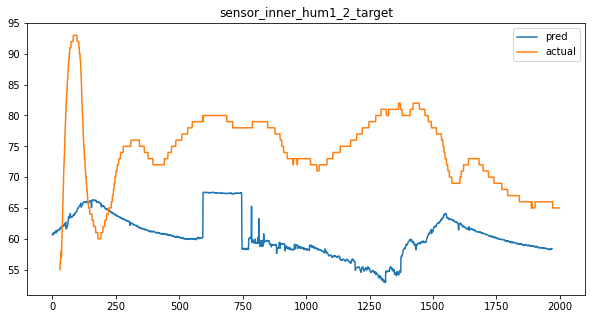

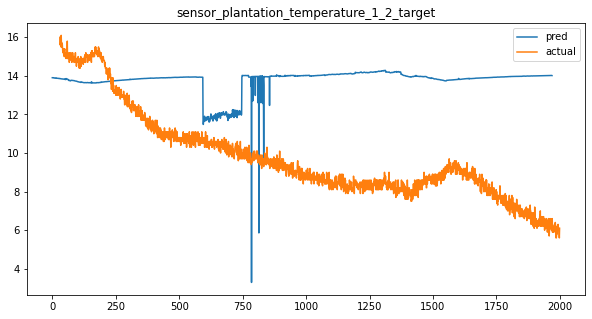

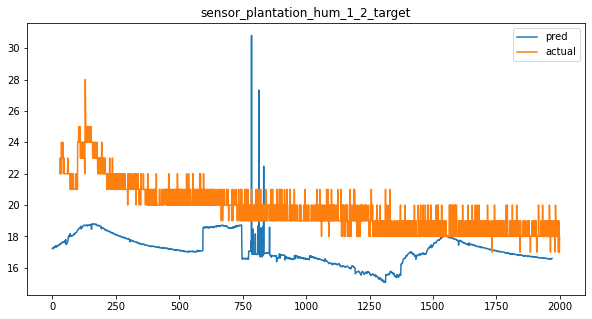

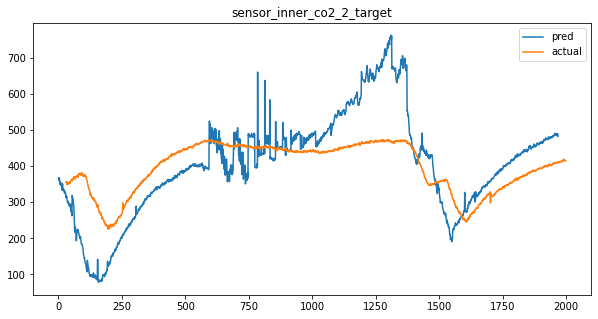

In [41]:
for col in list(pred_df):
    plt.figure(figsize = (10,5))
    plt.plot(pred_df[col][:])
    plt.plot(actual_df[col][:])
    plt.legend(['pred','actual'])
    plt.title(col)
    plt.show()
    input()